In [2]:
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely

import contextily as cx
import matplotlib.pyplot as plt
import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
#from damagescanner.base_values import DICT_CIS_VULNERABILITY_FLOOD
import rasterio
import geopandas as gpd
from rasterio.mask import mask
import rioxarray

from lonboard import viz
import requests
from rasterio.windows import from_bounds

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

In [3]:
country_full_name = 'Angola'
country_iso3 = 'AGO'

In [4]:
city_path = gpd.read_file('/Users/ipshitakarmakar/Dropbox (Personal)/WB/Angola/AOI/Huambo.shp')
city_path.set_crs(epsg=4326, inplace=True)

,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,GID_3,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
0,AGO,Angola,AGO.9_1,Huambo,NA,AGO.9.5_1,Huambo,NA,AGO.9.5.1_1,Chipipa,NA,NA,Commune,Commune,NA,NA,"POLYGON ((15.8424 -12.55896, 15.84247 -12.5590..."


There is a lot more that you can do with outputs (such as including interactive outputs)
with your book. For more information about this, see [the Jupyter Book documentation](https://jupyterbook.org)

In [5]:
features= gpd.read_file('/Users/ipshitakarmakar/Documents/infrastructure/mnt/city-directories/Infrastructure/Shapefiles/huambo_revised/Lines/Existing/15kv/huambo_15kv_existing_underground.shp')

In [6]:
clipped_features = gpd.clip(features, city_path)
clipped_features["object_type"] = "Cable"

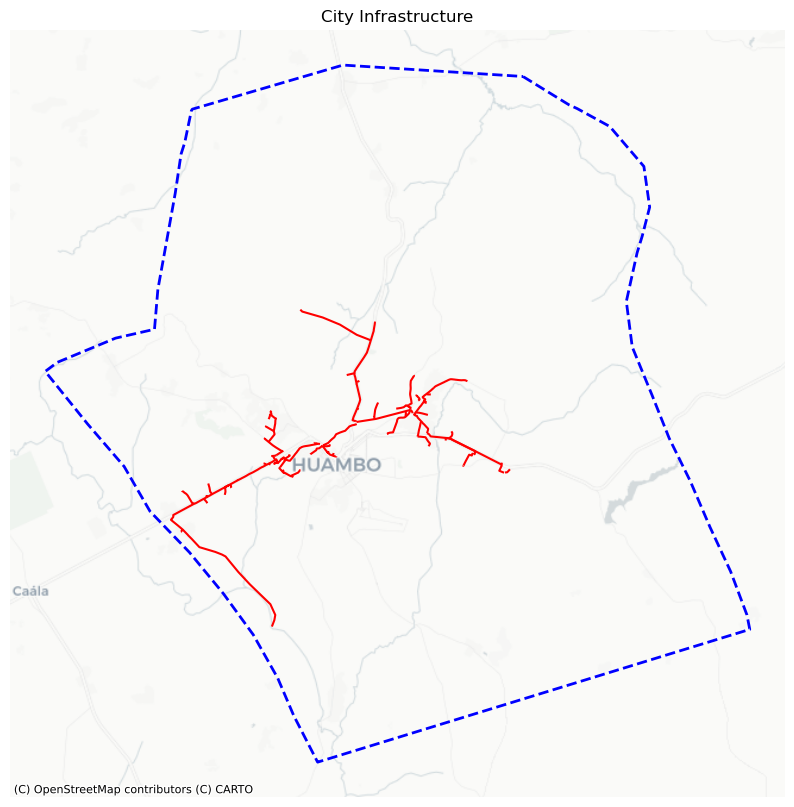

In [7]:
clipped_features_3857 = clipped_features.to_crs(epsg=3857)
city_path_3857 = city_path.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))
clipped_features_3857.plot(ax=ax, edgecolor='red', facecolor='none')
city_path_3857.plot(ax=ax, edgecolor='blue', facecolor='none', lw=2, linestyle='--')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_title('City Infrastructure')
plt.axis("off")
plt.show()

In [8]:
sub_types = clipped_features.object_type.unique()

In [9]:
sub_types

array(['Cable'], dtype=object)

In [10]:
url = 'https://gpm.nasa.gov/sites/default/files/downloads/global-landslide-susceptibility-map-2-27-23.tif'
hazard_map = 'global_landslide_susceptibility_map.tif'

# Send HTTP GET request
response = requests.get(url, stream=True)

# Check if the request was successful
if response.status_code == 200:
    with open(hazard_map, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"Downloaded successfully to {hazard_map}")
else:
    print(f"Failed to download. Status code: {response.status_code}")

Downloaded successfully to global_landslide_susceptibility_map.tif


In [11]:
hazard_map

'global_landslide_susceptibility_map.tif'

In [12]:
maxdam_dict = {'Cable':300}

In [13]:
maxdam = pd.DataFrame.from_dict(maxdam_dict,orient='index').reset_index()
maxdam.columns = ['object_type','damage']

In [14]:
missing = set(sub_types) - set(maxdam.object_type)

if len(missing) > 0:
    print(f"Missing object types in maxdam: \033[1m{', '.join(missing)}\033[0m. Please add them before you continue.")

In [15]:
vulnerability_path = "https://zenodo.org/records/10203846/files/Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx?download=1"
vul_df = pd.read_excel(vulnerability_path,sheet_name='F_Vuln_Depth')

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
  display(vul_df.iloc[:2,:].T)

,0,1
ID number,Infrastructure description,Additional characteristics
F1.1,plant,"Small power plants, capacity <100 MW"
F1.2,plant,"Medium power plants, capacity 100-500 MW"
F1.3,plant,"Large power plants, >500 MW"
F1.4,plant,thermal plant
F1.5,plant,wind turbine
F1.6,plant,wind turbine
F1.7,plant,wind turbine
F2.1,substation,Low Voltage Substation
F2.2,substation,Medium Voltage Substation


In [17]:
sub_types

array(['Cable'], dtype=object)

In [18]:
selected_curves = dict(zip(sub_types,['F2.1','F2.2']))

In [19]:
damage_curves = vul_df[['ID number']+list(selected_curves.values())]
damage_curves = damage_curves.iloc[4:125,:]

In [20]:
damage_curves.set_index('ID number',inplace=True)
damage_curves.index = damage_curves.index.rename('Depth')  

In [21]:
damage_curves = damage_curves.astype(np.float32)

In [22]:
damage_curves.columns = sub_types

In [23]:
damage_curves = damage_curves.fillna(method='ffill')

In [24]:
damage_curves.index = damage_curves.index*100

In [25]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

In [26]:
admin1 = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_1_states_provinces.shp")

In [27]:
clipped_features = features.rename(columns = {'Cable' : 'object_type'})

In [28]:
country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry

In [29]:
country_gdf = gpd.GeoDataFrame(geometry=country_geom, crs="EPSG:4326")
clipped_country = gpd.clip(country_gdf, city_path)

In [30]:
hazard_map = 'global_landslide_susceptibility_map.tif'
with rasterio.open(hazard_map) as hazard_map:
    minx, miny, maxx, maxy = (country_bounds.minx.values[0],
                              country_bounds.miny.values[0],
                              country_bounds.maxx.values[0],
                              country_bounds.maxy.values[0])

    # Create a window based on the bounding box
    window = from_bounds(minx, miny, maxx, maxy, hazard_map.transform)
    
    # Read the raster data within the window
    hazard_clip = hazard_map.read(1, window=window)
    
    # Reprojecting the hazard_clip using rioxarray
    # Using rioxarray for easier handling of CRS
    hazard_country = rioxarray.open_rasterio(hazard_map)
    
    # Reproject to EPSG:3857 (Web Mercator)
    hazard_3857 = hazard_country.rio.reproject("EPSG:3857")


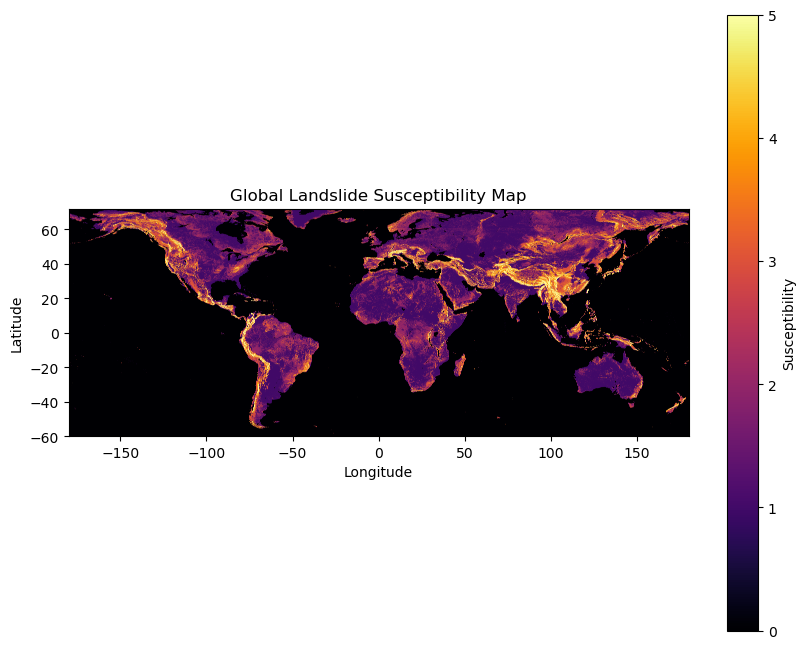

In [36]:
hazard_map = 'global_landslide_susceptibility_map.tif'
with rasterio.open(hazard_map) as src:
    hazard_data = src.read(1)  # read the first band
    hazard_bounds = src.bounds
    hazard_crs = src.crs
plt.figure(figsize=(10, 8))
plt.imshow(hazard_data, cmap='inferno', extent=[hazard_bounds.left, hazard_bounds.right,
                                                 hazard_bounds.bottom, hazard_bounds.top])
plt.title('Global Landslide Susceptibility Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Susceptibility')
plt.grid(False)
plt.show()

In [ ]:
clipped_features_3857 = clipped_features.to_crs(epsg=3857)
hazard_country_3857 = country_gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))
hazard_3857.plot(ax=ax, cmap="Blues", vmin=0)
clipped_features_3857.plot(ax=ax, edgecolor='red', facecolor='none')
hazard_country_3857.plot(ax=ax, edgecolor='blue', facecolor='none', lw=2, linestyle='--')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.title("Hazard_Country")
plt.axis("off")
plt.show()

In [41]:
hazard_city = hazard_country.rio.clip(city_path.geometry, city_path.crs, drop=True, all_touched=True)
hazard_city = hazard_city.where(hazard_city > 0)

In [32]:
clipped_features = clipped_features.to_crs("EPSG:3857")

# 2. Buffer in meters (e.g., 10 meters)
clipped_features["geometry"] = clipped_features.geometry.buffer(1)

# 3. Project back to original CRS (e.g., EPSG:4326)
features = clipped_features.to_crs("EPSG:4326")

In [3]:
hazard_city_3857 = hazard_city.rio.reproject("EPSG:3857")

# Reproject vector layers
city_path_3857 = city_path.to_crs(epsg=3857)
features_3857 = features.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot raster
hazard_plot = hazard_city_3857.plot(ax=ax, cmap="Blues", vmin=0, add_colorbar=True)

# Plot vector layers
city_path_3857.plot(ax=ax, edgecolor='blue', facecolor='none', lw=2, linestyle='--', label='City Path')
features_3857.plot(ax=ax, edgecolor='red', facecolor='none', label='Features')

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Add colorbar
cbar = fig.colorbar(hazard_plot, ax=ax, shrink=0.5, orientation='horizontal', pad=0.01, aspect=20)
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Hazard Intensity", fontsize=9)

# Add legend
ax.legend(loc='lower right', fontsize='small', frameon=True)

# Final formatting
plt.title("Landslides")
plt.axis("off")
plt.tight_layout()
plt.show()

NameError: name 'hazard_city' is not defined

In [1]:

warnings.filterwarnings("ignore", category=UserWarning, message="Geometry is in a geographic CRS")

def prepare_features(features_gdf, hazard_crs=None):
    """
    Cleans and prepares a GeoDataFrame for overlay operations with a raster.
    
    - Fixes invalid geometries.
    - Drops null or empty geometries.
    - Aligns CRS with raster CRS.
    """
    
    # Step 1: Drop rows with missing or empty geometries
    features_gdf = features_gdf[features_gdf.geometry.notnull()]
    features_gdf = features_gdf[~features_gdf.geometry.is_empty]

    # Step 2: Check for invalid geometries
    invalid = features_gdf[~features_gdf.is_valid]
    print(f"Found {len(invalid)} invalid geometries.")

    if len(invalid) > 0:
        print("Attempting to fix invalid geometries with buffer(0)...")
        features_gdf['geometry'] = features_gdf['geometry'].buffer(0)

    # Step 3: Drop any geometries that are still invalid or become empty
    features_gdf = features_gdf[features_gdf.is_valid]
    features_gdf = features_gdf[~features_gdf.geometry.is_empty]

    # Step 4: Keep only polygon-type geometries (optional, depending on use case)
    features_gdf = features_gdf[features_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

    # Step 5: Reproject to raster CRS if needed
    if hazard_crs and features_gdf.crs != hazard_crs:
        print("Reprojecting vector data to match raster CRS...")
        features_gdf = features_gdf.to_crs(hazard_crs)

    print(f"Prepared {len(features_gdf)} geometries.")
    return features_gdf


NameError: name 'warnings' is not defined

In [ ]:
import rioxarray
hazard_map.rio.write_crs("EPSG:4326", inplace=True)  # only if CRS is missing; replace with actual EPSG if known
hazard_crs = hazard_map.rio.crs
features_cleaned = prepare_features(features, hazard_crs=hazard_crs)

In [ ]:
exposure_results = DamageScanner(hazard_city, features, damage_curves, maxdam).exposure()